In [5]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Embedding, concatenate, Reshape, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings("ignore")
BATCH_SIZE = 32
EPOCHS = 300
ec = LabelEncoder() # encode the categorical status
sc = StandardScaler() # scale the whole dataset to make the model learn faster

class status_LSTM:
    def __init__(self, eq_id, hour_horizontal, hour_vertical):
        self.eq_id = eq_id
        self.status_table = self.query_status()
        self.hour_horizontal = hour_horizontal
        self.hour_vertical = hour_vertical
        
        self.start_date = self.status_table.iloc[0]["TIMESTAMP_START"].date() + timedelta(days=1) # add one day to make it start from 00:00:00
        self.end_date = self.status_table.iloc[len(self.status_table)-1]["TIMESTAMP_START"].date()
        self.important_state_name = ["Break down Maintenance", "Utility Problem", "Maintenance", "IT Problem", \
                                    "Waiting For Spares", "MOTOR ERROR", "Half Yearly PM", "IT Maintenance", \
                                    "Machine Failure", "HANG UP", "Waiting For Repair", "BAD WEDGE FORM", "INDEXER PROBLEM",\
                                    "PC Buyoff Failed", "SHORT TAIL", "WIRE BREAK"]
        
        self.timeframe_table = self.generate_time(self.start_date.strftime("%d/%m/%Y"), self.end_date.strftime("%d/%m/%Y"), \
                                                  self.hour_horizontal, self.hour_vertical)

        self.impt_state_seq, self.impt_duration_seq = self.status_sequence(self.timeframe_table, self.status_table, important="YES")
        self.major_down_arr = self.major_down(self.timeframe_table, self.status_table, 6, 3600)
         
    def query_status(self):
            try:
                oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
                engine = create_engine(
                    oracle_string.format(
                        username = 'TFM4CEBERUS',
                        password = 'TFM4CEBERUS',
                        hostname = 'ome-db.bth.infineon.com',
                        port = '1538',
                        database = 'ome'
                        )
                    )
            except Exception as e:
                print(str(e))

            query = f"""select EQ_ID, TIMESTAMP_START, TIMESTAMP_END, DURATION, STATE_NAME, LEVEL3_NAME, LEVEL3 
                    from (SELECT
                      eq.eq_id, eq.name, eq.eq_type_ident
                    , data.timestamp_start,data.timestamp_end
                    , ROUND((data.timestamp_end - data.timestamp_start)*24*60*60,0) AS Duration
                    , data.tr25_3_status,data.tr25_4_status,data.tr25_5_status,data.eq_status
                    , level5s.state_name
                    , level5.state_name Level5_Name, level5.state_sign Level5
                    , level4.state_name Level4_Name, level4.state_sign Level4
                    , level3.state_name Level3_Name, level3.state_sign Level3
                    ,mh.device
                    ,mh.package,
                    mh.lotid as lot,
                    mh.product,
                    mh.operation

                    FROM OMEDATA.EQUIPMENT_STATE_HISTORY data
                    , OMEADMIN.EQUIPMENT_INSTANCES eq
                    , V_EQ_STATES level5s
                    , OMEADMIN.DEF_STANDARD_STATEMODEL level5
                    , OMEADMIN.DEF_STANDARD_STATEMODEL level4
                    , OMEADMIN.DEF_STANDARD_STATEMODEL level3
                    , OMEDATA.METAKEY_HISTORY mh

                    WHERE data.eq_ident  = eq.eq_ident
                    AND  data.eq_status = level5s.state_ident(+)
                    AND level5.state_ident = data.tr25_5_status
                    AND level4.state_ident = data.tr25_4_status
                    AND level3.state_ident = data.tr25_3_status
                    AND  data.metakey_ident =mh.ident(+)
                    and data.timestamp_start > sysdate - 1050)
                    where eq_id = '{self.eq_id}'
                    ORDER BY TIMESTAMP_START"""

            status = pd.read_sql(query, engine)
            status.columns = map(lambda x: str(x).upper(), status.columns) 

            return status

    def generate_time(self, start_date:str, end_date:str, hours_row:int, hour:int):
        start = datetime.strptime(start_date, '%d/%m/%Y')
        end = datetime.strptime(end_date, '%d/%m/%Y')

        dates = []
        while start+timedelta(hours=hours_row)<=end:
            row = [start, start+timedelta(hours=hours_row)]
            dates.append(row)
            start += timedelta(hours=hour)

        return pd.DataFrame(dates, columns=['TIMESTAMP_START', 'TIMESTAMP_END'])


    def major_down(self, input_df, status_table, hour, threshold):
            hour = pd.Timedelta(hours=hour)
            major_down = []
            
            # timeframe table must be a subset of the status table to correctly determine major down
            if status_table.iloc[0]["TIMESTAMP_START"] >= input_df.iloc[0]["TIMESTAMP_START"]:
                raise Exception("Timeframe table must be a subset of the status table")
            if status_table.iloc[len(status_table)-1]["TIMESTAMP_START"] <= input_df.iloc[len(input_df)-1]["TIMESTAMP_START"]:
                raise Exception("Timeframe table must be a subset of the status table")

            for idx, row in input_df.iterrows():
                start = row['TIMESTAMP_END']
                end = start+hour
                frame = status_table[(status_table['TIMESTAMP_START']>start) & (status_table['TIMESTAMP_START']<end)]
                UD = frame.loc[frame['LEVEL3']=='UDT']

                if len(UD) == 0: #no record within this 6 hours:
                    major_down.append(0)
                else:
                    time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
                    if any(time_diff>threshold):
                        major_down.append(1)
                    else:
                        major_down.append(0)
            return major_down

    def status_sequence(self, input_table, status_table, important=None):
        status_seq = []
        duration_seq = []
        
        # validation check
        if status_table.iloc[0]["TIMESTAMP_START"] > input_table.iloc[0]["TIMESTAMP_START"]:
            raise Exception("Timeframe table must be a subset of the status table")
        if status_table.iloc[len(status_table)-1]["TIMESTAMP_START"] <= input_table.iloc[len(input_table)-1]["TIMESTAMP_START"]:
                raise Exception("Timeframe table must be a subset of the status table")
        
        for idx, row in input_table.iterrows():
            start = row["TIMESTAMP_START"]
            end = row["TIMESTAMP_END"]
            
            condition = (status_table["TIMESTAMP_START"]>=start) & (status_table["TIMESTAMP_START"]<=end)
            if important == "YES":
                condition = (status_table["TIMESTAMP_START"]>=start) & (status_table["TIMESTAMP_START"]<=end) & \
                                (status_table.STATE_NAME.isin(self.important_state_name))
            
            table = status_table[condition]
            status_seq.append(table["STATE_NAME"].values)
            duration_seq.append(table["DURATION"].values)

        return status_seq, duration_seq

    def preprocess(self, status_seq, duration_seq):
        X_seq = []
        for ele, dur in zip(status_seq, duration_seq):
            tmp = []
            for idx in range(len(ele)):
                tmp.append([ele[idx], int(dur[idx])])
            X_seq.append(tmp)
        return np.array(X_seq)

# Training without excluding unimportant state name
##### Skipped for now, training took too long (one epoch 30 mins!) as the padded time stamp contains too many status values 

In [2]:
# hour = 24
# start = datetime.now()
# print(f"Training by looking back {hour} hours of alarm data")
# wba124 = status_LSTM("WBA124", hour, 3)

# # pad the alarm to train on LSTM
# unpadded_status_arr = wba124.encoded_status_seq
# unpadded_duration_arr = wba124.duration_seq

# padded_status_arr = np.zeros([len(unpadded_status_arr),len(max(unpadded_status_arr,key = lambda x: len(x)))])
# padded_duration_arr = np.zeros([len(unpadded_duration_arr),len(max(unpadded_duration_arr,key = lambda x: len(x)))])
# for i,j in enumerate(unpadded_status_arr):
#     padded_status_arr[i][0:len(j)] = j
#     padded_duration_arr[i][0:len(j)] = unpadded_duration_arr[i]

# # standard scale for the model to learn faster
# padded_X_seq = wba124.preprocess(padded_status_arr, padded_duration_arr)
# for i in range(padded_X_seq.shape[1]):
#     padded_X_seq[:, i, :] = sc.fit_transform(padded_X_seq[:, i, :])

# #train_val_test split
# val_percentage = 0.2
# test_percentage = 0.1

# test_index = int(len(padded_X_seq) * (1-test_percentage))
# val_index = int(len(padded_X_seq) * (1- val_percentage - test_percentage))

# X_train_seq, X_val_seq, X_test_seq = padded_X_seq[:val_index], padded_X_seq[val_index:test_index], padded_X_seq[test_index:]
# y_train_seq, y_val_seq, y_test_seq = wba124.major_down_arr[:val_index], wba124.major_down_arr[val_index:test_index], wba124.major_down_arr[test_index:]

# X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 2)
# X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[1], 2)
# X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 2)

In [3]:
# ## Training took too long, one epoch 30 MINS!!! ##
# seq_result = {}

# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(y_train_seq),
#                                              y_train_seq)
# class_weights_dict = dict(enumerate(class_weights))

# #need to reinitialize the model because x_train_seq changes in shape
# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train_seq.shape[1:]), return_sequences=True))
# model.add(Dropout(0.5))

# model.add(LSTM(128, input_shape=(X_train_seq.shape[1:])))
# model.add(Dropout(0.5))

# model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(0.2))

# model.add(Dense(2, activation = 'softmax'))

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(np.array(X_train_seq), np.array(y_train_seq), 
#                 batch_size=BATCH_SIZE, epochs=EPOCHS, 
#                 validation_data=(np.array(X_val_seq), np.array(y_val_seq)),
#                 class_weight = class_weights_dict)

# evaluate = model.evaluate(np.array(X_test_seq), np.array(y_test_seq)) #loss, mse

# seq_result[hour] = evaluate
# end = datetime.now()
# time = end - start
# print(f"Training took a total of {time.seconds} seconds")

# Training with only important state name and duration
## Padding the sequence with max length

In [ ]:
def compile_and_train(X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq):
    """
    Returns the evaluation score for the model
    """
    class_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train_seq),
                                             y_train_seq)
    class_weights_dict = dict(enumerate(class_weights))

    #need to reinitialize the model because x_train_seq changes in shape
    model = Sequential()
    model.add(LSTM(256, input_shape=(X_train_seq.shape[1:]), return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(256, input_shape=(X_train_seq.shape[1:])))
    model.add(Dropout(0.5))

    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(np.array(X_train_seq), np.array(y_train_seq), 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(np.array(X_val_seq), np.array(y_val_seq)),
                    class_weight = class_weights_dict)

    evaluate = model.evaluate(np.array(X_test_seq), np.array(y_test_seq)) #loss, mse
    return evaluate

In [5]:
seq_result = {}
# lookback = [24,48,72,96]

# for hour in lookback:
hour = 12
start = datetime.now()
print(f"Training by looking back {hour} hours of important STATE NAME data")
wba124 = status_LSTM("WBA124", hour, 3)

# pad the alarm to train on LSTM
unpadded_status_arr = wba124.encoded_impt_state_seq
unpadded_duration_arr = wba124.impt_duration_seq

padded_status_arr = np.zeros([len(unpadded_status_arr),len(max(unpadded_status_arr,key = lambda x: len(x)))])
padded_duration_arr = np.zeros([len(unpadded_duration_arr),len(max(unpadded_duration_arr,key = lambda x: len(x)))])
for i,j in enumerate(unpadded_status_arr):
    padded_status_arr[i][0:len(j)] = j
    padded_duration_arr[i][0:len(j)] = unpadded_duration_arr[i]

# standard scale for the model to learn faster
padded_X_seq = wba124.preprocess(padded_status_arr, padded_duration_arr)
for i in range(padded_X_seq.shape[1]):
    padded_X_seq[:, i, :] = sc.fit_transform(padded_X_seq[:, i, :])

#train_val_test split
val_percentage = 0.2
test_percentage = 0.1

test_index = int(len(padded_X_seq) * (1-test_percentage))
val_index = int(len(padded_X_seq) * (1- val_percentage - test_percentage))

X_train_seq, X_val_seq, X_test_seq = padded_X_seq[:val_index], padded_X_seq[val_index:test_index], padded_X_seq[test_index:]
y_train_seq, y_val_seq, y_test_seq = wba124.major_down_arr[:val_index], wba124.major_down_arr[val_index:test_index], wba124.major_down_arr[test_index:]

X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 2)
X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[1], 2)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 2)

# train and evaluate the model
evaluate = compile_and_train(X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq)

seq_result[hour] = evaluate
end = datetime.now()
time = end - start
print(f"Training took a total of {time.seconds} seconds")

Training by looking back 12 hours of important STATE NAME data
Epoch 1/100
184/184 [==============================] - 311s 2s/step - loss: 0.7231 - accuracy: 0.6478 - val_loss: 0.7749 - val_accuracy: 0.6466
Epoch 2/100
184/184 [==============================] - 306s 2s/step - loss: 0.6856 - accuracy: 0.7147 - val_loss: 0.7434 - val_accuracy: 0.6436
Epoch 3/100
184/184 [==============================] - 308s 2s/step - loss: 0.6854 - accuracy: 0.7670 - val_loss: 0.7929 - val_accuracy: 0.6442
Epoch 4/100
184/184 [==============================] - 302s 2s/step - loss: 0.6791 - accuracy: 0.7599 - val_loss: 0.7272 - val_accuracy: 0.6472
Epoch 5/100
184/184 [==============================] - 305s 2s/step - loss: 0.6819 - accuracy: 0.7747 - val_loss: 0.7005 - val_accuracy: 0.6472
Epoch 6/100
184/184 [==============================] - 305s 2s/step - loss: 0.6775 - accuracy: 0.7858 - val_loss: 0.6901 - val_accuracy: 0.6478
Epoch 7/100
184/184 [==============================] - 304s 2s/step - los

In [6]:
seq_result

{12: [0.6964600682258606, 0.07508939504623413]}

In [10]:
X_train_seq.shape # this is padded with the max length of all sequences

(5872, 127, 2)

# Training with only important state name and duration
## Padding the sequence with the average length
#### https://towardsdatascience.com/using-tensorflow-ragged-tensors-2af07849a7bd
#### Apparently can also greatly help boost accracy

In [23]:
seq_result = {}

lookback = [12,24,48,72,96]
for hour in lookback:
    start = datetime.now()
    print(f"Training by looking back {hour} hours of important STATE NAME data")
    wba124 = status_LSTM("WBA124", hour, 3)

    # pad the alarm to train on LSTM
    unpadded_status_arr = wba124.encoded_impt_state_seq
    unpadded_duration_arr = wba124.impt_duration_seq

    mean_length = int(np.mean([len(x) for x in unpadded_status_arr]))
    padded_status_arr = np.zeros([len(unpadded_status_arr), mean_length])
    padded_duration_arr = np.zeros([len(unpadded_duration_arr), mean_length])

    for i,j in enumerate(unpadded_status_arr):
        padded_status_arr[i][0:len(j)] = j[:mean_length]
        padded_duration_arr[i][0:len(unpadded_duration_arr[i])] = unpadded_duration_arr[i][:mean_length]

    # standard scale for the model to learn faster
    padded_X_seq = wba124.preprocess(padded_status_arr, padded_duration_arr)
    for i in range(padded_X_seq.shape[1]):
        padded_X_seq[:, i, :] = sc.fit_transform(padded_X_seq[:, i, :])

    #train_val_test split
    val_percentage = 0.2
    test_percentage = 0.1

    test_index = int(len(padded_X_seq) * (1-test_percentage))
    val_index = int(len(padded_X_seq) * (1- val_percentage - test_percentage))

    X_train_seq, X_val_seq, X_test_seq = padded_X_seq[:val_index], padded_X_seq[val_index:test_index], padded_X_seq[test_index:]
    y_train_seq, y_val_seq, y_test_seq = wba124.major_down_arr[:val_index], wba124.major_down_arr[val_index:test_index], wba124.major_down_arr[test_index:]

    X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 2)
    X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[1], 2)
    X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 2)
    
    # train and evaluate the model
    evaluate = compile_and_train(X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq)

    seq_result[hour, mean_length] = evaluate
    end = datetime.now()
    time = end - start
    print(f"Training took a total of {time.seconds} seconds")

Training by looking back 12 hours of important STATE NAME data
Epoch 1/100
184/184 [==============================] - 7s 24ms/step - loss: 0.6573 - accuracy: 0.6008 - val_loss: 0.6721 - val_accuracy: 0.5317
Epoch 2/100
184/184 [==============================] - 4s 20ms/step - loss: 0.6587 - accuracy: 0.6308 - val_loss: 0.7247 - val_accuracy: 0.5287
Epoch 3/100
184/184 [==============================] - 4s 20ms/step - loss: 0.6578 - accuracy: 0.6294 - val_loss: 0.7386 - val_accuracy: 0.5179
Epoch 4/100
184/184 [==============================] - 4s 20ms/step - loss: 0.6577 - accuracy: 0.6369 - val_loss: 0.6469 - val_accuracy: 0.5329
Epoch 5/100
184/184 [==============================] - 4s 20ms/step - loss: 0.6568 - accuracy: 0.6388 - val_loss: 0.6866 - val_accuracy: 0.5400
Epoch 6/100
184/184 [==============================] - 4s 20ms/step - loss: 0.6561 - accuracy: 0.6448 - val_loss: 0.7881 - val_accuracy: 0.4671
Epoch 7/100
184/184 [==============================] - 4s 20ms/step - los

Epoch 1/100
183/183 [==============================] - 29s 145ms/step - loss: 0.6942 - accuracy: 0.5405 - val_loss: 0.6265 - val_accuracy: 0.8406
Epoch 2/100
183/183 [==============================] - 26s 141ms/step - loss: 0.6867 - accuracy: 0.5602 - val_loss: 0.7821 - val_accuracy: 0.3649
Epoch 3/100
183/183 [==============================] - 26s 142ms/step - loss: 0.6895 - accuracy: 0.5961 - val_loss: 0.7141 - val_accuracy: 0.4386
Epoch 4/100
183/183 [==============================] - 26s 142ms/step - loss: 0.6836 - accuracy: 0.5972 - val_loss: 0.6407 - val_accuracy: 0.7669
Epoch 5/100
183/183 [==============================] - 28s 152ms/step - loss: 0.6902 - accuracy: 0.5288 - val_loss: 0.7047 - val_accuracy: 0.4272
Epoch 6/100
27/27 [==============================] - 1s 41ms/step - loss: 0.7332 - accuracy: 0.3353
Training took a total of 278 seconds


In [24]:
seq_result

{(12, 6): [0.6557784676551819, 0.6348448395729065],
 (24, 12): [0.6868782043457031, 0.5519713163375854],
 (48, 24): [0.7382815480232239, 0.4169653654098511],
 (72, 37): [0.6986674070358276, 0.5454545617103577],
 (96, 49): [0.7332104444503784, 0.3353293538093567]}

# Training with Embedding Layer, multiple inputs

### one categorical variable + one numerical variable
#### model overfits very badly, introduce some callbacks and Dropout
#### TODO: check if the target value is computed correctly, values looks suspicious

In [6]:
def label_encode(statename_seq): # do this the manual way as we are not certain if sklearn LabelEncoder can handle 3D array
    all_unique_statename = [set(ele) for ele in statename_seq]
    unique_statenames = set()
    for ele in all_unique_statename:
        unique_statenames |= ele
    
    enc_label = 1  #start encoding from 1 as we have to pad the sequence with 0
    mapping_dict = {}
    for ele in unique_statenames:
        mapping_dict[ele] = enc_label
        enc_label += 1

        enc_array = []
        
    #X_seq is a 3D array
    for timestamp in statename_seq:
        tmp_arr = []
        for ele in timestamp:
            tmp_arr.append(mapping_dict[ele])
        enc_array.append(np.array(tmp_arr))

    return np.array(enc_array), len(unique_statenames)+1

In [7]:
def remove_empty_datapoint(impt_state_seq, impt_duration_seq, major_down_arr):
    print(f"Remove {len([ele for ele in impt_state_seq if len(ele)==0])} rows on WBA124 out of {len(impt_state_seq)} as it has no data")
    bool_arr = [len(ele)==0 for ele in impt_state_seq] #this is to find the index to remove for bot y array and X_seq
    idx_remove = np.where(bool_arr)[0]
    
    major_down_arr = np.delete(np.array(major_down_arr), idx_remove) # remove the corresponding y value as well
    impt_state_seq = np.delete(impt_state_seq, idx_remove) #remove rows with no state name
    impt_duration_seq = np.delete(impt_duration_seq, idx_remove)
    return impt_state_seq, impt_duration_seq, major_down_arr

In [8]:
def randomly_select_negative(X_seq, X_dur, major_down_arr, ratio):
    bool_arr = [ele==0 for ele in major_down_arr]
    major_arr = np.array(major_down_arr)[np.where(bool_arr)[0]]
    print(len(major_arr), len(major_down_arr))
    negative = X_seq[np.where(bool_arr)[0]]
    duration = X_dur[np.where(bool_arr)[0]]
    
    positive_bool_arr = [ele==1 for ele in major_down_arr]
    positive_major_arr = np.array(major_down_arr)[np.where(positive_bool_arr)[0]]
    print(len(positive_major_arr))
    positive = X_seq[np.where(positive_bool_arr)[0]]
    positive_dur = X_dur[np.where(positive_bool_arr)[0]]
    
    discard, keep, dur_discard, dur_keep, target_discard, target_keep = train_test_split(negative, duration, major_arr, test_size=ratio)
    
    handpicked = np.concatenate((positive, keep))
    dur = np.concatenate((positive_dur, dur_keep))
    target = np.concatenate((positive_major_arr, target_keep))
    
    if len(handpicked) != len(dur) or len(handpicked) != len(target):
        raise Exception("Length of training inputs are different")
    
    return handpicked, dur, target

In [9]:
seq_result = {}
lookback = [12, 24, 48, 72]
count = 0
mode = "max"
for hour in lookback:
    if count  == 0:
        monitor = "val_recall"
    else:
        monitor = f"val_recall_{count}"
    
    count += 1
    #NEW MACHINES WITH LITTLE DATA: 120, 121 122, 125
    #CAN USE 123, 124, 126, 127, 128, 129, 130, 131, 132, 133
    wba123 = status_LSTM("WBA123", hour, 3)
    wba124 = status_LSTM("WBA124", hour, 3)
    wba126 = status_LSTM("WBA126", hour, 3)
    wba127 = status_LSTM("WBA127", hour, 3)
    wba128 = status_LSTM("WBA128", hour, 3)
    
    #remove data points
    wba123.impt_state_seq, wba123.impt_duration_seq, wba123.major_down_arr = remove_empty_datapoint(wba123.impt_state_seq, wba123.impt_duration_seq, wba123.major_down_arr)
    wba124.impt_state_seq, wba124.impt_duration_seq, wba124.major_down_arr = remove_empty_datapoint(wba124.impt_state_seq, wba124.impt_duration_seq, wba124.major_down_arr)
    wba126.impt_state_seq, wba126.impt_duration_seq, wba126.major_down_arr = remove_empty_datapoint(wba126.impt_state_seq, wba126.impt_duration_seq, wba126.major_down_arr)
    wba127.impt_state_seq, wba127.impt_duration_seq, wba127.major_down_arr = remove_empty_datapoint(wba127.impt_state_seq, wba127.impt_duration_seq, wba127.major_down_arr)
    wba128.impt_state_seq, wba128.impt_duration_seq, wba128.major_down_arr = remove_empty_datapoint(wba128.impt_state_seq, wba128.impt_duration_seq, wba128.major_down_arr)

    start = datetime.now()
    tmp1 = np.concatenate((wba123.impt_state_seq, wba124.impt_state_seq, wba126.impt_state_seq, wba127.impt_state_seq, wba128.impt_state_seq))
    encoded_X_seq, n_statename = label_encode(tmp1)
    numerical_X_seq = np.concatenate((wba123.impt_duration_seq, wba124.impt_duration_seq, wba126.impt_duration_seq, wba127.impt_duration_seq, wba128.impt_duration_seq,)) # one numerical variable (duration associated with the statename)
    target = np.concatenate((wba123.major_down_arr, wba124.major_down_arr, wba126.major_down_arr, wba127.major_down_arr, wba128.major_down_arr, ))
    
    # downsample negative data
    encoded_X_seq, numerical_X_seq, target = randomly_select_negative(encoded_X_seq, numerical_X_seq,  target, 0.2)
    
    #shuffle the X and Y values to make generalize better
    shuffled = shuffle(encoded_X_seq, numerical_X_seq, target)
    encoded_X_seq = shuffled[0]
    numerical_X_seq = shuffled[1]
    target = shuffled[2]
    
    # padding to average length
    mean_length = int(np.mean([len(x) for x in encoded_X_seq]))
    padded_statename = np.zeros([len(encoded_X_seq), mean_length])
    padded_duration = np.zeros([len(encoded_X_seq), mean_length])
    for i,j in enumerate(encoded_X_seq):
        padded_statename[i][0:len(j)] = j[:mean_length]
        padded_duration[i][0:len(j)] = numerical_X_seq[i][:mean_length]

    #train_val_test split
    X_train_statename_seq, X_val_statename_seq, X_train_duration_seq, X_val_duration_seq, y_train_seq, y_val_seq =  train_test_split(padded_statename, padded_duration, target, test_size=0.4, random_state=42, stratify=target)
    X_val_statename_seq, X_test_statename_seq, X_val_duration_seq, X_test_duration_seq, y_val_seq, y_test_seq =  train_test_split(X_val_statename_seq, X_val_duration_seq, y_val_seq, test_size=0.4, random_state=42, stratify=y_val_seq)    
    
    # embed the categorical variable using Keras Functional API
    in_layer = Input(shape=(X_train_statename_seq.shape[1],), name="statename")
    em_layer = Embedding(n_statename, 128, mask_zero=True)(in_layer)
    em_layer = Reshape((X_train_statename_seq.shape[1], -1))(em_layer)

    # input layer for numerical variable
    in_num = Input(shape=(X_train_duration_seq.shape[1], 1), name="duration")

    merge = concatenate([em_layer, in_num])
    lstm_layer1 = Bidirectional(LSTM(128, return_sequences=True))(merge)
    dropout1 = Dropout(0.5)(lstm_layer1)
    lstm_layer2 = LSTM(64)(dropout1)
    dropout2 = Dropout(0.5)(lstm_layer2)
    dense = Dense(64, activation='relu')(dropout2)
    classifier = Dense(1, activation='sigmoid')(dense)

    all_inputs = [in_layer, in_num]
    model = Model(inputs=all_inputs, outputs=classifier)

    # model seems to be overfitting, try to reduce overfitting by reduce LR, but model should take longer to converge so use a larger EPOCH
    callbacks = [ReduceLROnPlateau(monitor=monitor, factor=0.2, patience=5, min_lr=0.001), \
                EarlyStopping(monitor=monitor, mode=mode, patience=30, restore_best_weights=True)]

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

    model.fit([X_train_statename_seq, X_train_duration_seq], y_train_seq,
             validation_data=([X_val_statename_seq, X_val_duration_seq], y_val_seq),
             callbacks=callbacks, epochs=EPOCHS, batch_size=BATCH_SIZE)

    evaluate = model.evaluate([X_test_statename_seq, X_test_duration_seq], y_test_seq) #loss, mse
    
    pred = model.predict([X_test_statename_seq, X_test_duration_seq])
    classes = []
    for ele in pred:
        classes.append(int((ele>0.5)[0]))

    from sklearn.metrics import classification_report, confusion_matrix

    cm = confusion_matrix(y_test_seq, classes)
    print(cm)
    
    seq_result[hour] = [evaluate, cm]

    end = datetime.now()
    time = end - start
    print(f"Training took {time.seconds} seconds to complete.")

Remove 2835 rows on WBA124 out of 8357 as it has no data
Remove 2971 rows on WBA124 out of 8381 as it has no data
Remove 2314 rows on WBA124 out of 8381 as it has no data
Remove 2760 rows on WBA124 out of 8381 as it has no data
Remove 2526 rows on WBA124 out of 8341 as it has no data
24669 28435
3766
Epoch 1/300
164/164 [==============================] - 11s 32ms/step - loss: 0.6794 - precision: 0.5102 - recall: 0.2996 - accuracy: 0.5722 - val_loss: 0.6777 - val_precision: 0.4975 - val_recall: 0.2190 - val_accuracy: 0.5661
Epoch 2/300
164/164 [==============================] - 4s 23ms/step - loss: 0.6762 - precision: 0.5288 - recall: 0.3288 - accuracy: 0.5826 - val_loss: 0.6743 - val_precision: 0.5114 - val_recall: 0.3960 - val_accuracy: 0.5747
Epoch 3/300
164/164 [==============================] - 4s 24ms/step - loss: 0.6777 - precision: 0.5109 - recall: 0.2491 - accuracy: 0.5716 - val_loss: 0.6735 - val_precision: 0.3333 - val_recall: 0.0100 - val_accuracy: 0.5627
Epoch 4/300
164/164

Epoch 36/300
164/164 [==============================] - 4s 24ms/step - loss: 0.6448 - precision: 0.5690 - recall: 0.4217 - accuracy: 0.6113 - val_loss: 0.6944 - val_precision: 0.5221 - val_recall: 0.4834 - val_accuracy: 0.5848
Epoch 37/300
164/164 [==============================] - 4s 24ms/step - loss: 0.6455 - precision: 0.5619 - recall: 0.4195 - accuracy: 0.6071 - val_loss: 0.6815 - val_precision: 0.5230 - val_recall: 0.3905 - val_accuracy: 0.5819
Epoch 38/300
164/164 [==============================] - 4s 23ms/step - loss: 0.6447 - precision: 0.5646 - recall: 0.4119 - accuracy: 0.6079 - val_loss: 0.6866 - val_precision: 0.5292 - val_recall: 0.4812 - val_accuracy: 0.5900
Epoch 39/300
164/164 [==============================] - 4s 24ms/step - loss: 0.6474 - precision: 0.5581 - recall: 0.4274 - accuracy: 0.6056 - val_loss: 0.6777 - val_precision: 0.5230 - val_recall: 0.3650 - val_accuracy: 0.5809
Epoch 40/300
164/164 [==============================] - 4s 25ms/step - loss: 0.6440 - precis

187/187 [==============================] - 7s 37ms/step - loss: 0.6704 - precision_1: 0.5017 - recall_1: 0.1757 - accuracy: 0.5866 - val_loss: 0.6722 - val_precision_1: 1.0000 - val_recall_1: 0.0020 - val_accuracy: 0.5871
Epoch 21/300
187/187 [==============================] - 7s 38ms/step - loss: 0.6690 - precision_1: 0.5024 - recall_1: 0.0852 - accuracy: 0.5865 - val_loss: 0.6703 - val_precision_1: 0.6176 - val_recall_1: 0.0213 - val_accuracy: 0.5896
Epoch 22/300
187/187 [==============================] - 7s 37ms/step - loss: 0.6699 - precision_1: 0.5063 - recall_1: 0.1314 - accuracy: 0.5875 - val_loss: 0.6751 - val_precision_1: 0.5179 - val_recall_1: 0.0294 - val_accuracy: 0.5871
Epoch 23/300
187/187 [==============================] - 7s 38ms/step - loss: 0.6696 - precision_1: 0.4979 - recall_1: 0.0982 - accuracy: 0.5858 - val_loss: 0.6707 - val_precision_1: 0.4841 - val_recall_1: 0.1856 - val_accuracy: 0.5812
Epoch 24/300
187/187 [==============================] - 7s 36ms/step - lo

202/202 [==============================] - 13s 64ms/step - loss: 0.6650 - precision_2: 0.4760 - recall_2: 0.0578 - accuracy: 0.5974 - val_loss: 0.6688 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.5996
Epoch 14/300
202/202 [==============================] - 13s 64ms/step - loss: 0.6651 - precision_2: 0.5037 - recall_2: 0.0532 - accuracy: 0.6000 - val_loss: 0.6687 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.5996
Epoch 15/300
202/202 [==============================] - 13s 64ms/step - loss: 0.6641 - precision_2: 0.5038 - recall_2: 0.0520 - accuracy: 0.6000 - val_loss: 0.6691 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.5996
Epoch 16/300
202/202 [==============================] - 13s 64ms/step - loss: 0.6659 - precision_2: 0.4432 - recall_2: 0.0454 - accuracy: 0.5951 - val_loss: 0.6700 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.5996
Epoch 17/300
202/202 [===============

209/209 [==============================] - 19s 89ms/step - loss: 0.6655 - precision_3: 0.4286 - recall_3: 0.0149 - accuracy: 0.6055 - val_loss: 0.6657 - val_precision_3: 0.2000 - val_recall_3: 9.5694e-04 - val_accuracy: 0.6065
Epoch 15/300
209/209 [==============================] - 19s 92ms/step - loss: 0.6632 - precision_3: 0.4098 - recall_3: 0.0096 - accuracy: 0.6058 - val_loss: 0.6657 - val_precision_3: 0.2500 - val_recall_3: 9.5694e-04 - val_accuracy: 0.6068
Epoch 16/300
209/209 [==============================] - 19s 90ms/step - loss: 0.6625 - precision_3: 0.5072 - recall_3: 0.0134 - accuracy: 0.6076 - val_loss: 0.6664 - val_precision_3: 0.5556 - val_recall_3: 0.0096 - val_accuracy: 0.6083
Epoch 17/300
209/209 [==============================] - 18s 88ms/step - loss: 0.6631 - precision_3: 0.4604 - recall_3: 0.0356 - accuracy: 0.6051 - val_loss: 0.6647 - val_precision_3: 0.4286 - val_recall_3: 0.0029 - val_accuracy: 0.6072
Epoch 18/300
209/209 [==============================] - 19s 9

In [10]:
seq_result # monitor val recall bidirectional

{12: [[0.6720257997512817,
   0.498251736164093,
   0.47342193126678467,
   0.5660919547080994],
  array([[503, 287],
         [317, 285]])],
 24: [[0.6715388298034668,
   0.49162012338638306,
   0.4012157917022705,
   0.5802391171455383],
  array([[658, 273],
         [394, 264]])],
 48: [[0.6704964637756348,
   0.4724026024341583,
   0.4229651093482971,
   0.5797438621520996],
  array([[705, 325],
         [397, 291]])],
 72: [[0.6639971137046814,
   0.4779660999774933,
   0.20229555666446686,
   0.6002252101898193],
  array([[925, 154],
         [556, 141]])]}

# Model Architecture

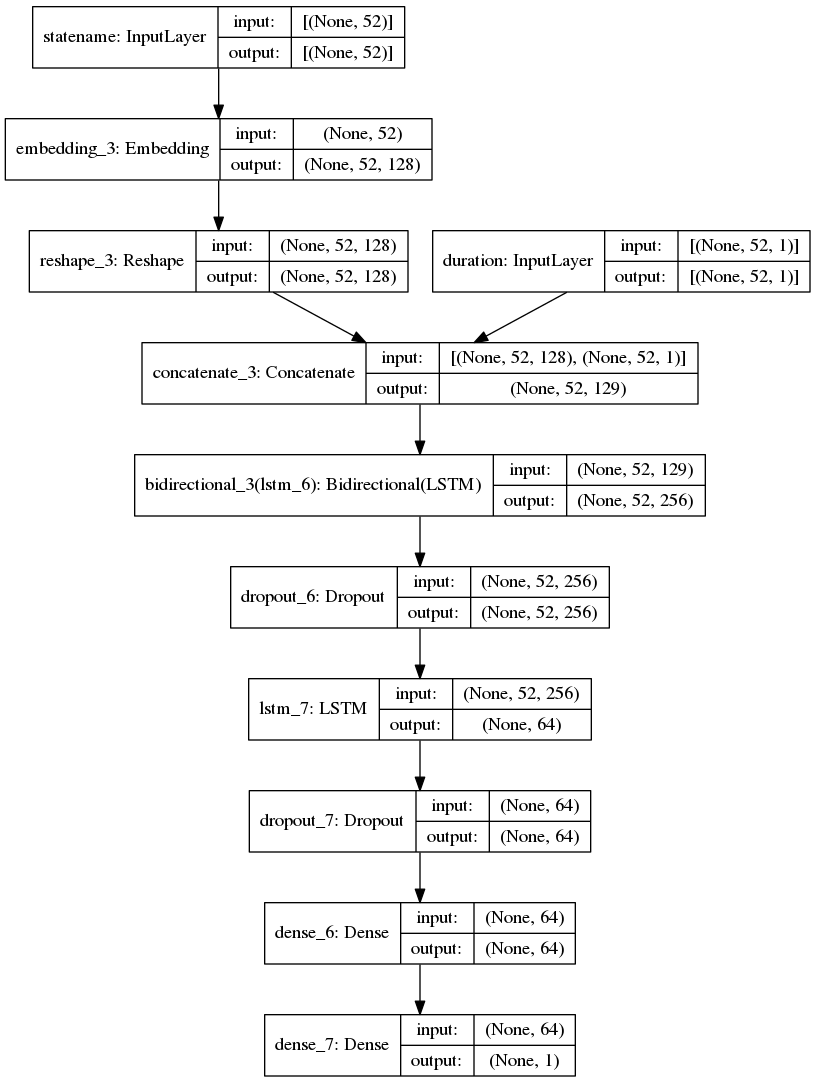

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(model, 'statename_seq.png', show_shapes=True, show_layer_names=True)